In [1]:
"""
read_ASOS108(): 서울 ASOS 자료를 pandas DataFrame 형태로 읽음
"""
import pandas as pd
import numpy as np
import os
def read_ASOS108():
    inpath = "../data/ASOS108"
    fnlist = os.listdir(inpath)
    dfs = []
    for fn in fnlist:
        df = pd.read_csv(os.path.join(inpath, fn), encoding='cp949')
        dfs.append(df)
    return pd.concat(dfs)
    
"""
process_cols(df, use_cols): 입력자료로 사용할 열 추출 및 생성, 자료의 전처리 단계
"""

def process_cols(df, use_cols):
    df['일강수량(mm)'] = df['일강수량(mm)'].fillna(0)
    df1 = df[use_cols].dropna()
    df1['datetime'] = pd.to_datetime(df1['일시'])
    df1['year'] = df1['datetime'].dt.year
    df1['month'] = df1['datetime'].dt.month
    df1['day'] = df1['datetime'].dt.day
    return df1.sort_values(by='datetime')
    
"""
split_data(df, date): date를 기준으로 앞은 학습기간, 뒤는 테스트기간으로 분류
"""
def split_data(df, date):
    datetime = df['datetime'][df['datetime'] >= date]
    train_df = df[df['datetime'] < date].drop('datetime', axis=1)
    test_df = df[df['datetime'] >= date].drop('datetime', axis=1)
    train_X = train_df.drop('Y', axis=1)
    train_y = train_df['Y']
    test_X = test_df.drop('Y', axis=1)
    test_y = test_df['Y']
    return train_X, train_y, test_X, test_y, datetime

"""
do_prediction(train_X, train_y, test_X, test_y): 학습기간으로 모델 학습 후 테스트기간 예측을 수행, 실제값과 예측값 간의 RMSE, 상관계수 반환
"""
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr
def do_prediction(train_X, train_y, test_X, test_y):
    model = LinearRegression()
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)


    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    corr, _ = pearsonr(test_y, predictions)
    return predictions, rmse, corr

"""
실제값과 예측값을 시각화
draw_scatter(test_y, predictions, rmse, corr): 산포도
draw_ts(test_y, predictions, datetime, rmse, corr): 시계열
"""
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def draw_scatter(test_y, predictions, rmse, corr):

    fig = px.scatter(x=test_y, y=predictions, labels={'x': 'Actual', 'y': 'Predicted'}, 
                    title=f'Real vs Predicted (RMSE: {rmse:.2f}, Corr: {corr:.2f})')
    fig.update_layout(
        xaxis=dict(scaleanchor="y", range=[-15, 15]),
        yaxis=dict(scaleanchor="x", range=[-15, 15]),
        width = 600,
        height = 600
    )

    fig.update_traces(marker=dict(size=2, opacity=0.6, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.show()

def draw_ts(test_y, predictions, datetime, rmse, corr):
    fig = go.Figure()

    # 실제값과 예측값 시각화
    fig.add_trace(go.Scatter(x=datetime, y=test_y, mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=datetime, y=predictions, mode='lines', name='Predicted', line=dict(color='red')))

    fig.update_layout(
        title=f'Real vs Predicted (RMSE: {rmse:.2f}, Corr: {corr:.2f})'
    )
    fig.show()

In [2]:
def remove_seasonal_cycle(df, use_cols):
    df['day_of_year'] = df['datetime'].dt.strftime('%m-%d')  # MM-DD 형식
    
    for col in use_cols[1:]:  # '일시' 제외
        seasonal_cycle = df.groupby('day_of_year')[col].mean()
        
        # 2월 29일 처리
        if '02-29' in seasonal_cycle:
            if '02-28' in seasonal_cycle and '03-01' in seasonal_cycle:
                seasonal_cycle['02-29'] = (seasonal_cycle['02-28'] + seasonal_cycle['03-01']) / 2
        
        df[f'{col}_seasonal_cycle'] = df['day_of_year'].map(seasonal_cycle)
        df[f'{col}_detrended'] = df[col] - df[f'{col}_seasonal_cycle']
    
    return df.drop(columns=['day_of_year'] + [f'{col}_seasonal_cycle' for col in use_cols[1:]])

In [3]:
df_raw = read_ASOS108()

use_cols = ['일시', '평균기온(°C)', '일강수량(mm)', '평균 풍속(m/s)', 
        '평균 이슬점온도(°C)', '평균 상대습도(%)', 
        '평균 현지기압(hPa)', '평균 전운량(1/10)', '합계 일사량(MJ/m2)']


df_raw1 = process_cols(df_raw, use_cols)
df_raw1 = remove_seasonal_cycle(df_raw1, use_cols)

target = '평균기온(°C)_detrended'
df_raw1['Y'] = df_raw1[target].shift(-1)

df_raw1 = df_raw1.iloc[:-1]

use_cols_detrend = df_raw1.columns
use_cols_detrend = [ col for col in use_cols_detrend if col not in use_cols]
df_raw1 = df_raw1[use_cols_detrend]



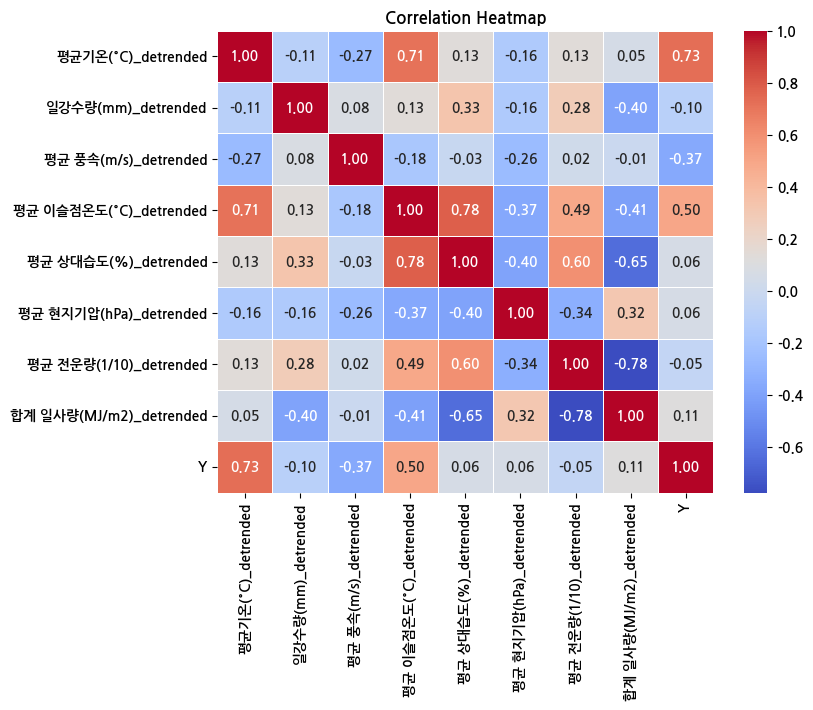

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
fn_font = 'NanumGothic.ttf' # 나눔고딕 폰트 사용
fontprop = fm.FontProperties(fname=fn_font)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=fontprop.get_name()) # matplotlib.pyplot을 쓸 때 이 폰트를 쓰겠다는 뜻

col_corr = df_raw1.columns.tolist()[4:]
df_corr = df_raw1[col_corr]
corr = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
df_raw = read_ASOS108()

use_cols = ['일시', '평균기온(°C)', '평균 풍속(m/s)', 
        '평균 이슬점온도(°C)']


df_raw1 = process_cols(df_raw, use_cols)
df_raw1 = remove_seasonal_cycle(df_raw1, use_cols)

target = '평균기온(°C)_detrended'
df_raw1['Y'] = df_raw1[target].shift(-1)

df_raw1 = df_raw1.iloc[:-1]

use_cols_detrend = df_raw1.columns
use_cols_detrend = [ col for col in use_cols_detrend if col not in use_cols]
df_raw1 = df_raw1[use_cols_detrend]

train_X, train_y, test_X, test_y, datetime = split_data(df_raw1, '2022-01-01')

predictions, rmse, corr = do_prediction(train_X, train_y, test_X, test_y)
print(corr, rmse)


0.7675681715429543 2.09676770308944
